# Библитеки

In [8]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, f1_score, make_scorer, plot_confusion_matrix, accuracy_score, \
     classification_report, precision_score, recall_score, confusion_matrix, balanced_accuracy_score

# for class
import scipy.stats as ss
import itertools
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict
from itertools import product

# for detect anomalies
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

from Modules.CheckerClass import Checker
from Modules.VisualisationClass import Vizualization
from Modules.DetectOutliersClass import DetectOutliers

# Обзор данных

In [9]:
data = pd.read_csv('C:/Users/malya/Desktop/Datasets/HR/HR Analytics Job Change of Data Scientists/aug_train.csv')
print(f"Количество строк: {data.shape[0]}, количество столбцов: {data.shape[1]}")
data.head()

Количество строк: 19158, количество столбцов: 14


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [11]:
Checker(data).check_missing(missing_edge=0.1)

,missing
experience,0.339284
enrolled_university,2.014824
last_new_job,2.207955
education_level,2.401086
major_discipline,14.683161
gender,23.530640
company_size,30.994885
company_type,32.049274


In [12]:
Checker(data).constant_values()

[]

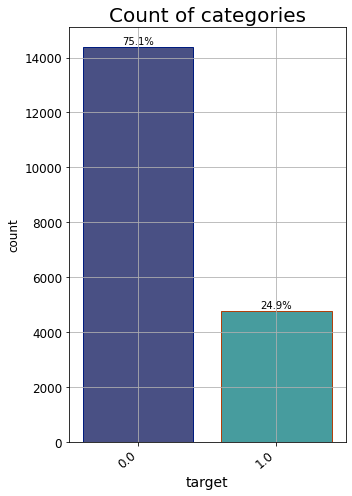

In [13]:
Checker(data).disbalance_target()

In [14]:
Checker(data).correlation(corr_edge=0, corr_method='pearson')

city_development_index  training_hours            0.001920
enrollee_id             training_hours            0.000998
training_hours          target                   -0.021577
enrollee_id             city_development_index   -0.040455
city_development_index  target                   -0.341665
dtype: float64

In [15]:
data_kramer = data.copy()
data_kramer['target'] = np.where(data_kramer['target']==1, 'A', 'B')
Checker(data_kramer).kramer_corr(kramer_edge=0.2)

experience           relevent_experience    0.397
last_new_job         relevent_experience    0.390
relevent_experience  enrolled_university    0.388
education_level      relevent_experience    0.317
enrolled_university  experience             0.253
last_new_job         experience             0.236
company_type         relevent_experience    0.205
dtype: float64

In [16]:
Checker(data).ppscore(pps_edge=0.2)

,x,y,ppscore
16,city,city_development_index,0.995505
29,city_development_index,city,0.851952
158,last_new_job,relevent_experience,0.396443
74,enrolled_university,relevent_experience,0.378410
116,experience,relevent_experience,0.349823
88,education_level,relevent_experience,0.262231


In [11]:
# Удаление признака 'enrollee_id'
del data['enrollee_id']

In [12]:
def drop_repite_rows(data, columns):
    # Удаление повторяющихся строк
    data_dropped = data.copy()
    data_dropped = data_dropped.drop_duplicates(subset=columns)
    print('Удалено строк - {}'. format(data.shape[0] - data_dropped.shape[0]))
    print('Размер данных - {} X {}'. format(data_dropped.shape[0], data_dropped.shape[1]))
    
    return data_dropped

data = drop_repite_rows(data, data.columns)

Удалено строк - 49
Размер данных - 19109 X 13


In [13]:
# Выделение признаков 
features = data.drop('target', axis=1)
# Выделение target
target = data['target']

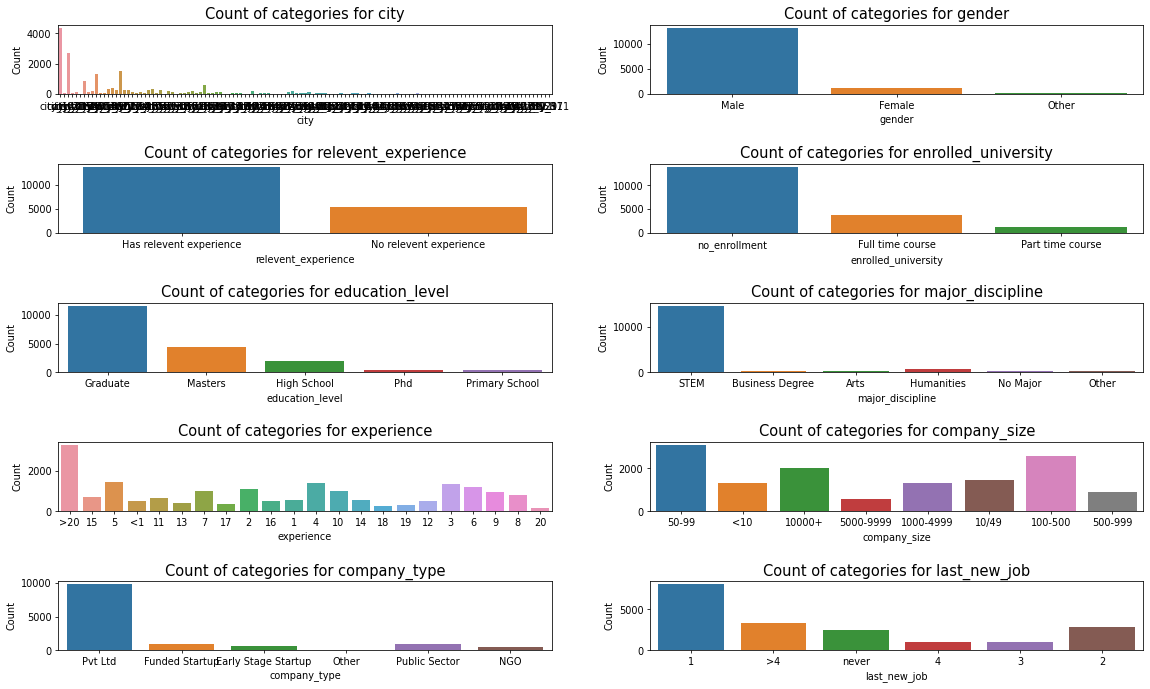

In [5]:
Vizualization(data).cat_histograms()

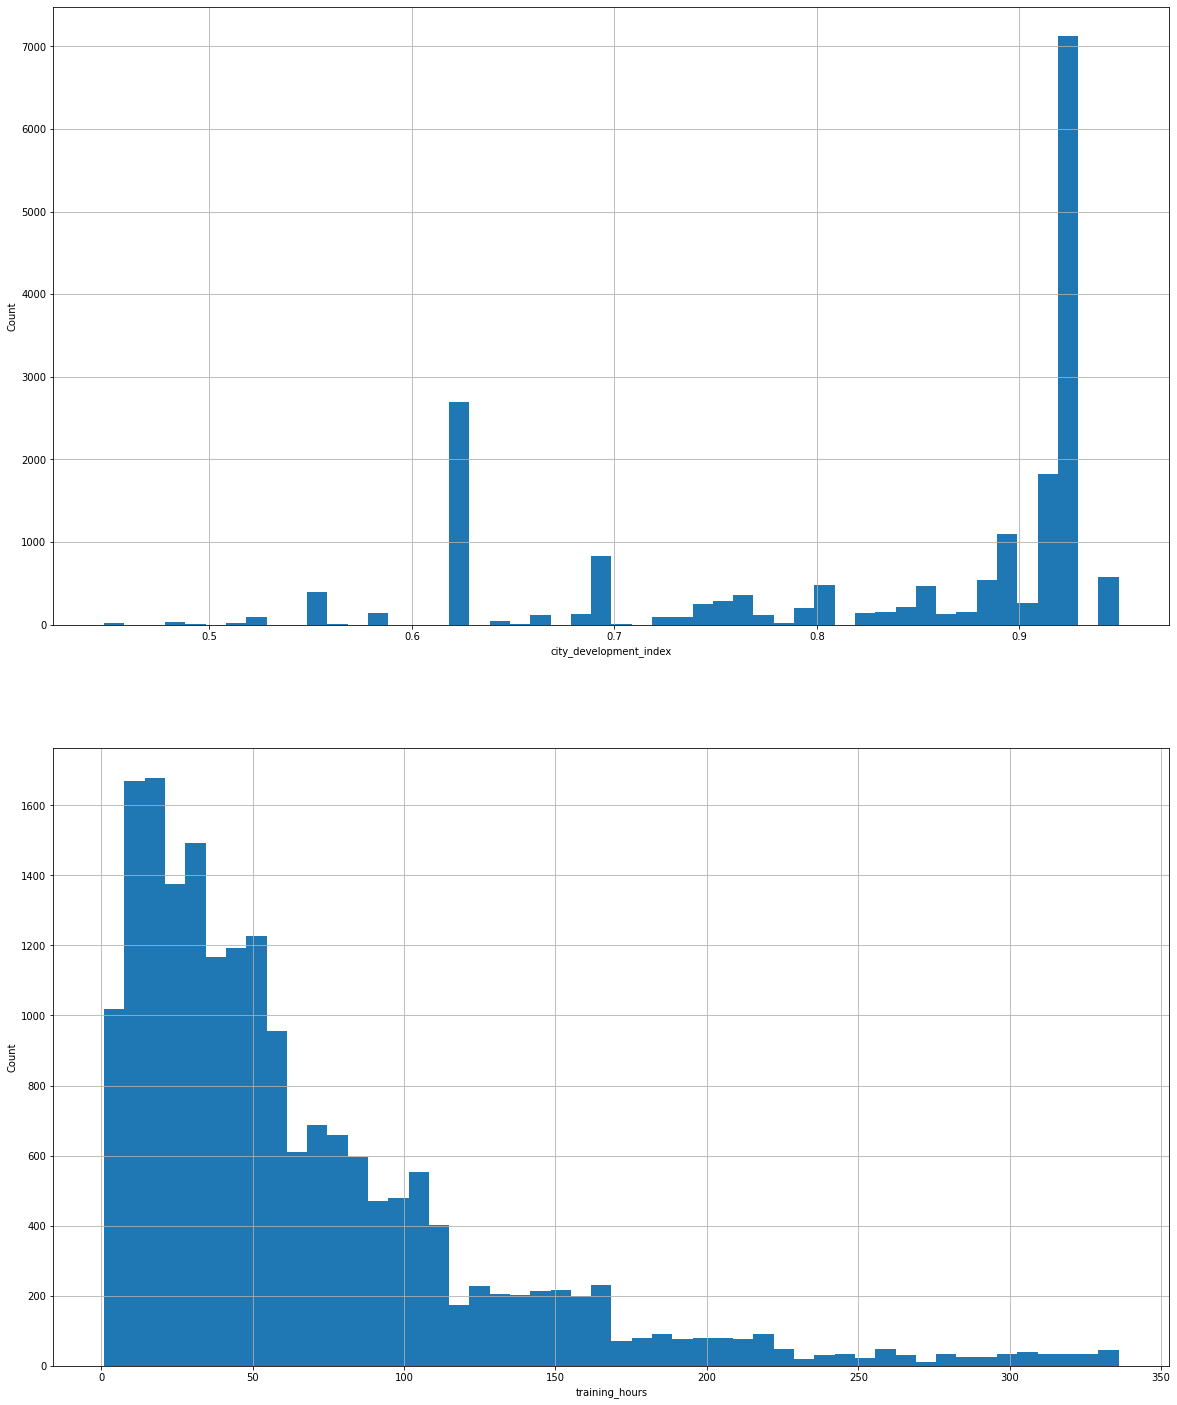

In [16]:
Vizualization(features).num_histograms()

# Поиск и удаление выбросов

In [7]:
test = DetectOutliers(data).outlier_detect_mean_std('training_hours')
test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,anomalies_training_hours_mean_std,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,1,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,1,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,1,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,1,0.0


# Feature Engineering

In [19]:
# Создадим наборы категориальных и количественных переменных
# Разделяем по при признаку object и не object
cat_columns_ =  features.select_dtypes(include='object').columns.tolist()
num_columns_ =  features.select_dtypes(exclude='object').columns.tolist()

## Количественные признаки

In [20]:
def poly_nam_features(data, features, N):
    """
    Объединение значений 2-х (3-х) количественных признаков
    Args:
        data - датафрейм
        features - список количественных признаков
        N - порядок генерируемого признака (полинома)
    """
    poly = PolynomialFeatures(degree=N,
                              include_bias=False,
                              interaction_only=False)
    poly.fit(data[features])
    values = poly.transform(data[features])
    poly_features = poly.get_feature_names()
    features_ = poly.get_feature_names()[:len(features)]

    j = -1
    for k in features_:
        j += 1
        for i in range(len(poly_features)):
            if poly_features[i].endswith(k):
                poly_features[i] = poly_features[i].replace(k, features[j])
    j = -1
    for k in features_:
        j += 1
        for i in range(len(poly_features)):
            if poly_features[i].startswith(k+' ') or poly_features[i].startswith(k+'^'):
                poly_features[i] = poly_features[i].replace(k, features[j])      


    return pd.DataFrame(values, columns=poly_features, index=data.index)

new_features_poly = poly_nam_features(features, num_columns_, 2)
features[new_features_poly.columns] = new_features_poly
features.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,city_development_index^2,city_development_index training_hours,training_hours^2
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36.0,0.846400,33.120,1296.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47.0,0.602176,36.472,2209.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83.0,0.389376,51.792,6889.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52.0,0.622521,41.028,2704.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8.0,0.588289,6.136,64.0


# Train test split

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(features,
                                                      target,
                                                      test_size=0.3,
                                                      stratify=target,
                                                      random_state=16)
print('Размер X_train - {} X {}'. format(X_train.shape[0], X_train.shape[1]))
print('Размер X_valid - {} X {}'. format(X_valid.shape[0], X_valid.shape[1]))

Размер X_train - 13376 X 15
Размер X_valid - 5733 X 15


In [22]:
def check_diff_categories(data, test_data):
    """
    Проверка наличия одних и тех же категорий в train и test
    """
    uni_lists = []
    uni_f = []
    cat_columns = data.select_dtypes(include='object').columns.tolist()
    
    for f in cat_columns:
        unique_cat_data = data[f].unique().tolist()
        unique_cat_test_data = test_data[f].unique().tolist()
        diff_cat = list(set(unique_cat_data) - set(unique_cat_test_data))
        if len(diff_cat) > 0:
            uni_lists.append(diff_cat)
            uni_f.append(f)
        uni_dict = dict(zip(uni_f, uni_lists))
        
    return uni_dict

In [23]:
check_diff_categories(X_train, X_valid)

{'city': ['city_167', 'city_140', 'city_121', 'city_139', 'city_129']}

In [24]:
check_diff_categories(X_valid, X_train)

{'city': ['city_171']}

## Укрупнение редких категорий

In [25]:
class RareGrouper(BaseEstimator, TransformerMixin):
    '''
        Укрупняет редкие категории классов в рамках одного признака
        Параметры:
            threshold: минимально допустимая относительная частота,
            при которой не происходит замены
    '''

    def __init__(self, threshold=0.01):
        self.d = defaultdict(list)
        self.threshold = threshold

    def fit(self, X, y=None):
        n_obs = len(X)
        for col in X.columns:
            rel_freq = X[col].value_counts(dropna=False) / n_obs
            self.d[col] = rel_freq[rel_freq >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = np.where(X[col].isin(self.d[col]), X[col], 'Other')
        return X

In [26]:
# Создадим наборы категориальных и количественных переменных
# Разделяем по при признаку object и не object
cat_columns_ =  X_train.select_dtypes(include='object').columns.tolist()
num_columns_ =  X_train.select_dtypes(exclude='object').columns.tolist()

In [27]:
for col in cat_columns_:
    raregrouper = RareGrouper(threshold=(30/20000))
    raregrouper.fit(X_train[[col]])
    X_train[col] = raregrouper.transform(X_train[[col]])
    X_valid[col] = raregrouper.transform(X_valid[[col]])

In [28]:
# X_train - X_test
check_diff_categories(X_train, X_valid)

{}

In [29]:
# X_test - X_train
check_diff_categories(X_valid, X_train)

{}

## TargetEncoding

In [30]:
X_train_te = X_train.copy()
X_valid_te = X_valid.copy()

In [31]:
X_train_te = pd.concat([X_train_te, y_train], axis='columns')
X_valid_te = pd.concat([X_valid_te, y_valid], axis='columns')

In [32]:
for col in cat_columns_:
    encoder = TargetEncoder(handle_missing='return_nan')
    encoder.fit(X_train_te[col], X_train_te['target'])
    X_train_te[col] = encoder.transform(X_train_te[col], X_train_te['target'])
    X_valid_te[col] = encoder.transform(X_valid_te[col], X_valid_te['target'])

In [33]:
del X_train_te['target']
del X_valid_te['target']

In [34]:
X_train_te.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,city_development_index^2,city_development_index training_hours,training_hours^2
7638,0.272727,0.745,0.227979,0.214427,0.210718,0.211166,0.262731,0.170526,0.174869,0.178373,0.179965,4.0,0.555025,2.980,16.0
7112,0.147059,0.843,NaN,0.338748,0.383686,0.281918,0.262731,0.307371,NaN,0.230530,NaN,28.0,0.710649,23.604,784.0
17323,0.217478,0.920,0.227979,0.214427,0.210718,0.281918,0.262731,0.178462,0.151856,0.178373,0.179965,67.0,0.846400,61.640,4489.0
13304,0.257576,0.754,0.227979,0.214427,0.247884,0.281918,0.262731,0.360825,0.186113,0.230530,0.264026,166.0,0.568516,125.164,27556.0
15043,0.227194,0.920,NaN,0.338748,0.383686,0.190645,NaN,0.342640,NaN,NaN,0.264026,143.0,0.846400,131.560,20449.0


# Modeling

In [35]:
# Обзорные таблицы с метриками лучших моделей
bestmodels_accuracy_list = []
bestmodels_metrics_list = []

## CatBoost + SimpleImputer

### Подготовка

In [36]:
cat_columns =  X_train.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid.select_dtypes(exclude='object').columns.tolist()

In [37]:
num_of_cat_cols = len(cat_columns)
cat_features_indices = [col for col in range(num_of_cat_cols)]

### Модель

In [38]:
# Конвейер для категориальных переменных
catbst_cat_pipe = Pipeline([('imp', SimpleImputer())])
# Конвейер для количественных переменных
catbst_num_pipe = Pipeline([('imp', SimpleImputer())])
# Трансформер
catbst_transformers = [('cat', catbst_cat_pipe, cat_columns),
                       ('num', catbst_num_pipe, num_columns)]
catbst_transformer = ColumnTransformer(transformers=catbst_transformers)

In [39]:
# Экземпляр CatBoost
catbst = CatBoostClassifier(n_estimators=100,
                            logging_level='Silent',
                            random_state=16,
                            cat_features=cat_features_indices)

In [40]:
# Параметры для GridSearchCV
catbst_param_grid = {
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'tf__num__imp__strategy': ['mean', 'median'],
    'catboost__max_depth': [2, 3, 4, 6, 8]
}

In [42]:
# Итоговый конвейер
model = Pipeline([('tf', catbst_transformer),
                  ('catboost', catbst)])

In [43]:
# Итоговый GridSearchCV
catbst_gs_simp = GridSearchCV(model,
                              catbst_param_grid,
                              cv=5,
                              return_train_score=False,
                              scoring=make_scorer(balanced_accuracy_score))

In [44]:
catbst_gs_simp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         ['city',
                                                                          'gender',
                                                                          'relevent_experience',
                                                                          'enrolled_university',
                                                                          'education_level',
                                                                          'major_discipline',
                                                                          'experience',
             

### Результаты

In [45]:
catbst_gs_simp.best_params_

{'catboost__max_depth': 6,
 'tf__cat__imp__strategy': 'constant',
 'tf__num__imp__strategy': 'mean'}

In [46]:
catbst_gs_simp.best_score_

0.7212205129733416

In [47]:
y_pred = catbst_gs_simp.predict(X_valid)
y_pred_proba = catbst_gs_simp.predict_proba(X_valid)

In [48]:
cm = confusion_matrix(y_valid, y_pred)

In [49]:
def plot_confusion_matrix(confusion_matrix):
    # Матрица ошибок
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(dpi=100)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion_matrix')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

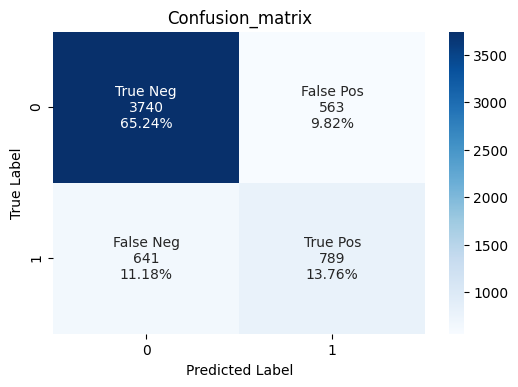

In [50]:
plot_confusion_matrix(cm)

In [51]:
# Результаты обучения модели 
cat_results = pd.DataFrame(catbst_gs_simp.cv_results_)
table = cat_results.pivot_table(values='mean_test_score',
                                index=['param_catboost__max_depth', 'param_tf__cat__imp__strategy', 'param_tf__num__imp__strategy'])
table = table.sort_values(by='mean_test_score', ascending=False)

In [52]:
# Запись лучшего значения для итогового сравнения моделей
best = catbst_gs_simp.cv_results_['mean_test_score'].max()
model_result_1 = pd.DataFrame([best], index=['CatBoost + SimpleImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_1)

In [53]:
def get_scores(y_true, y_pred, y_pred_proba, name):
    # Таблица с метриками обученной модели
    report = pd.DataFrame(columns=['Accuracy', 
                                   'ROC-AUC',
                                   'F1', 
                                   'Precision_0', 
                                   'Precision_1', 
                                   'Recall_0', 
                                   'Recall_1'], 
                          index=[name])
    report['Accuracy'] = accuracy_score(y_true, y_pred)
    report['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
    report['F1'] = f1_score(y_true, y_pred)
    report['Precision_0'] = precision_score(y_true, y_pred, pos_label=0)
    report['Precision_1'] = precision_score(y_true, y_pred, pos_label=1)
    report['Recall_0'] = recall_score(y_true, y_pred, pos_label=0)
    report['Recall_1'] = recall_score(y_true, y_pred, pos_label=1)
    return report

# Запись значений метрик для итогового сравнения моделей
model_metrics_1 = get_scores(y_valid, y_pred, y_pred_proba, 'CatBoost + SimpleImputer')
bestmodels_metrics_list.append(model_metrics_1)

## CatBoost + SMOTE + SimpleImputer

### Подготовка

In [54]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

In [55]:
num_of_cat_cols = len(cat_columns)
cat_features_indices = [col for col in range(num_of_cat_cols)]

### Модель

In [56]:
# Конвейер для категориальных переменных
catbst_cat_pipe = PipelineImb([('imp', SimpleImputer())])
# Конвейер для всех количественных переменных
catbst_num_pipe = PipelineImb([('imp', SimpleImputer()),
                              ('norm', MinMaxScaler())])


catbst_transformers = [('cat', catbst_cat_pipe, cat_columns),
                       ('num', catbst_num_pipe, num_columns)]

# Трансформер
catbst_transformer = ColumnTransformer(transformers=catbst_transformers)

In [57]:
# Экземпляр CatBoost
catbst = CatBoostClassifier(n_estimators=100,
                            logging_level='Silent',
                            random_state=16,
                            cat_features=cat_features_indices)

In [58]:
# Параметры для GridSearchCV
catbst_param_grid = {
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'tf__num__imp__strategy': ['mean', 'median'],
    'catboost__max_depth': [2, 3, 4, 6, 8]
}

In [59]:
# Итоговый конвейер
model = PipelineImb([('tf', catbst_transformer),
                     ('sampling', SMOTE()),
                     ('catboost', catbst)])

In [60]:
# Итоговый GridSearchCV
catbst_gs_ossimp = GridSearchCV(model,
                              catbst_param_grid,
                              cv=5,
                              return_train_score=False,
                              scoring=make_scorer(balanced_accuracy_score))

In [61]:
catbst_gs_ossimp.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('norm',
                                                                                          MinMaxScaler())]),
                                                                         ['cit

### Результаты

In [62]:
catbst_gs_ossimp.best_params_

{'catboost__max_depth': 2,
 'tf__cat__imp__strategy': 'most_frequent',
 'tf__num__imp__strategy': 'mean'}

In [63]:
catbst_gs_ossimp.best_score_

0.758261150151198

In [64]:
y_pred = catbst_gs_ossimp.predict(X_valid_te)
y_pred_proba = catbst_gs_ossimp.predict_proba(X_valid_te)

In [65]:
cm = confusion_matrix(y_valid, y_pred)

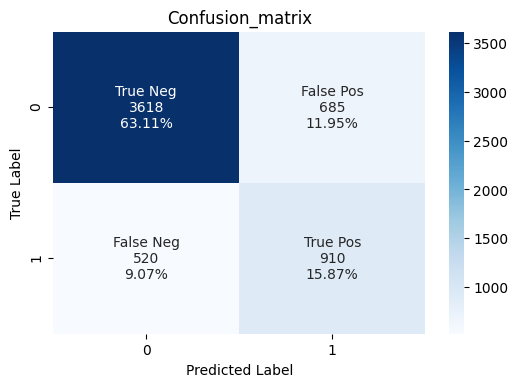

In [66]:
plot_confusion_matrix(cm)

In [67]:
# Результаты обучения модели 
cat_results = pd.DataFrame(catbst_gs_ossimp.cv_results_)
table = cat_results.pivot_table(values='mean_test_score',
                                index=['param_catboost__max_depth', \
                                       'param_tf__cat__imp__strategy', \
                                       'param_tf__num__imp__strategy'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_catboost__max_depth param_tf__cat__imp__strategy param_tf__num__imp__strategy                 
2                         most_frequent                mean                                 0.758261
                          constant                     mean                                 0.757263
3                         most_frequent                mean                                 0.754453
                          constant                     mean                                 0.754305
4                         most_frequent                mean                                 0.751702
                          constant                     mean                                 0.751702
6                         constant                     mean                                 0.748548
                          most_frequent                mean                                 0.744654
8                         most_frequent                mean                                 0.740650
                          constant                     mean                                 0.739097
2                         constant                     median                               0.716588
                          most_frequent                median                               0.716549
3                         most_frequent                median                               0.715286
                          constant                     median                               0.713831
6                         constant                     median                               0.713225
4                         constant                     median                               0.712829
8                         constant                     median                               0.712024
6                         most_frequent                median                               0.711723
4                         most_frequent                median                               0.709371
8                         most_frequent                median                               0.709270

In [68]:
# Запись лучшего значения для итогового сравнения моделей
best = catbst_gs_ossimp.cv_results_['mean_test_score'].max()
model_result_2 = pd.DataFrame([best], index=['CatBoost + SMOTE + SimpleImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_2)

In [69]:
# Запись значений метрик для итогового сравнения моделей
model_metrics_2 = get_scores(y_valid, y_pred, y_pred_proba, 'CatBoost + SMOTE + SimpleImputer')
bestmodels_metrics_list.append(model_metrics_2)

## CatBoost + KNNImputer

### Подготовка

In [70]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

In [71]:
num_of_cat_cols = len(cat_columns)
cat_features_indices = [col for col in range(num_of_cat_cols)]

### Модель

In [72]:
catbst_mix_pipe = Pipeline([('scaler', MinMaxScaler())])

catbst_transformers = [('mix', catbst_mix_pipe, num_columns)]
catbst_transformer = ColumnTransformer(transformers=catbst_transformers)

In [73]:
# Экземпляр CatBoost
catbst = CatBoostClassifier(n_estimators=100,
                            logging_level='Silent',
                            random_state=16,
                            cat_features=cat_features_indices)

In [74]:
# Итоговый конвейер
model = Pipeline([('tf', catbst_transformer),
                  ('imputer', KNNImputer()),
                  ('catboost', catbst)])

In [75]:
# Параметры для GridSearchCV
catbst_param_grid = {
    'catboost__max_depth': [2, 3, 4, 6, 8],
    'imputer__n_neighbors': [13, 17, 21]
}

In [76]:
# Итоговый GridSearchCV
catbst_gs_knn = GridSearchCV(model,
                              catbst_param_grid,
                              cv=5,
                              return_train_score=False,
                              scoring=make_scorer(balanced_accuracy_score))

In [77]:
catbst_gs_knn.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('mix',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['city',
                                                                          'city_development_index',
                                                                          'gender',
                                                                          'relevent_experience',
                                                                          'enrolled_university',
                                                                          'education_level',
                                                                          'major_discipline',

### Результаты

In [78]:
catbst_gs_knn.best_params_

{'catboost__max_depth': 6, 'imputer__n_neighbors': 21}

In [79]:
catbst_gs_knn.best_score_

0.6908602738515008

In [80]:
y_pred = catbst_gs_knn.predict(X_valid_te)
y_pred_proba = catbst_gs_knn.predict_proba(X_valid_te)

In [81]:
cm = confusion_matrix(y_valid, y_pred)

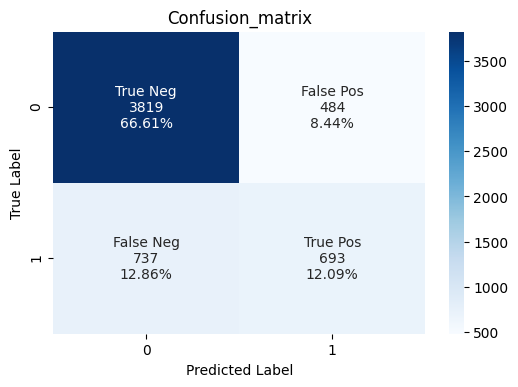

In [82]:
plot_confusion_matrix(cm)

In [83]:
cat_results = pd.DataFrame(catbst_gs_knn.cv_results_)
table = cat_results.pivot_table(values='mean_test_score',
                                index=['param_catboost__max_depth', 'param_imputer__n_neighbors'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_catboost__max_depth param_imputer__n_neighbors                 
6                         21                                 0.690860
                          13                                 0.690304
4                         21                                 0.690301
                          17                                 0.689453
                          13                                 0.688546
6                         17                                 0.687563
8                         21                                 0.687007
                          13                                 0.686060
                          17                                 0.681114
3                         17                                 0.680397
                          21                                 0.680299
                          13                                 0.675443
2                         21                                 0.668941
                          17                                 0.664236
                          13                                 0.663482

In [84]:
best = catbst_gs_knn.cv_results_['mean_test_score'].max()
model_result_3 = pd.DataFrame([best], index=['CatBoost + KNNImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_3)

In [85]:
model_metrics_3 = get_scores(y_valid, y_pred, y_pred_proba, 'CatBoost + KNNImputer')
bestmodels_metrics_list.append(model_metrics_3)

## RandomForestClassifier + SimpleImputer

### Подготовка

In [86]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

### Модель

In [87]:
randforest_cat_pipe = Pipeline([('imp', SimpleImputer())])
randforest_num_pipe = Pipeline([('imp', SimpleImputer())])
randforest_transformers = [('cat', randforest_cat_pipe, cat_columns),
                           ('num', randforest_num_pipe, num_columns)]
randfor_transformer = ColumnTransformer(transformers=randforest_transformers)

In [88]:
randfor = RandomForestClassifier(n_estimators=50)

In [89]:
# Итоговый конвейер
randfor_pipe = Pipeline([('tf', randfor_transformer),
                        ('randforest', randfor)])

In [90]:
# Параметры для GridSearchCV
randfor_param_grid = {
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'tf__num__imp__strategy': ['mean', 'median'],
    'randforest__max_depth':[2, 3, 4, 6]
}

In [91]:
# Итоговый GridSearchCV
randfor_gs_simp = GridSearchCV(randfor_pipe,
                               randfor_param_grid,
                               cv=5,
                               return_train_score=False,
                               scoring=make_scorer(balanced_accuracy_score))

In [92]:
randfor_gs_simp.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         ['city',
                                                                          'city_development_index',
                                                                          'gender',
                 

### Результаты

In [93]:
randfor_gs_simp.best_params_

{'randforest__max_depth': 6,
 'tf__cat__imp__strategy': 'most_frequent',
 'tf__num__imp__strategy': 'mean'}

In [94]:
y_pred = randfor_gs_simp.predict(X_valid_te)
y_pred_proba = randfor_gs_simp.predict_proba(X_valid_te)

In [95]:
cm = confusion_matrix(y_valid, y_pred)

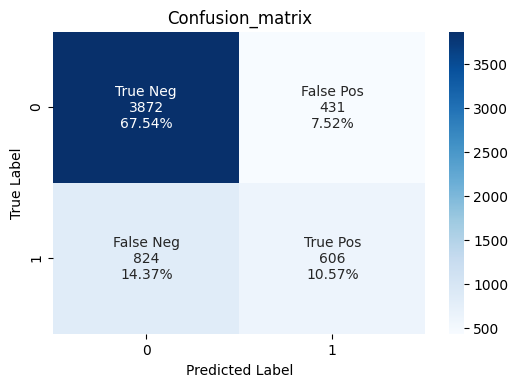

In [96]:
plot_confusion_matrix(cm)

In [97]:
ranforest_results = pd.DataFrame(randfor_gs_simp.cv_results_)
table = ranforest_results.pivot_table(values='mean_test_score',
                                index=['param_randforest__max_depth', 'param_tf__cat__imp__strategy', 'param_tf__num__imp__strategy'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_randforest__max_depth param_tf__cat__imp__strategy param_tf__num__imp__strategy                 
6                           most_frequent                mean                                 0.671645
                            constant                     mean                                 0.669847
                            most_frequent                median                               0.661544
                            constant                     median                               0.661244
4                           most_frequent                median                               0.661095
                            constant                     mean                                 0.660246
                                                         median                               0.659995
3                           constant                     mean                                 0.659693
                            most_frequent                median                               0.658594
                            constant                     median                               0.658193
4                           most_frequent                mean                                 0.658093
3                           most_frequent                mean                                 0.652441
2                           constant                     mean                                 0.632875
                                                         median                               0.622668
                            most_frequent                mean                                 0.617271
                                                         median                               0.613969

In [98]:
best = randfor_gs_simp.cv_results_['mean_test_score'].max()
model_result_4 = pd.DataFrame([best], index=['RandomForestClassifier + SimpleImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_4)

In [99]:
model_metrics_4 = get_scores(y_valid, y_pred, y_pred_proba, 'RandomForestClassifier + SimpleImputer')
bestmodels_metrics_list.append(model_metrics_4)

## RandomForestClassifier + SMOTE + SimpleImputer

### Подготовка

In [100]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

### Модель

In [172]:
randforest_cat_pipe = PipelineImb([('imp', SimpleImputer())])
randforest_num_pipe = PipelineImb([('imp', SimpleImputer()),
                                  ('norm', MinMaxScaler())])
randforest_transformers = [('cat', randforest_cat_pipe, cat_columns),
                           ('num', randforest_num_pipe, num_columns)]
randfor_transformer = ColumnTransformer(transformers=randforest_transformers)

In [173]:
# Создаем экземпляр класса CatBoost
randfor = RandomForestClassifier(n_estimators=50)

In [174]:
# Итоговый конвейер
model = PipelineImb([('tf', randfor_transformer),
                     ('sampling', SMOTE()),
                     ('randforest', randfor)])

In [175]:
# Параметры для GridSearchCV
randfor_param_grid = {
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'tf__num__imp__strategy': ['mean', 'median'],
    'randforest__max_depth': [2, 3, 4, 6, 8]
}

In [176]:
# Итоговый GridSearchCV
randfor_gs_ossimp = GridSearchCV(model,
                                 randfor_param_grid,
                                 cv=5,
                                 return_train_score=False,
                                 scoring=make_scorer(balanced_accuracy_score))

In [106]:
randfor_gs_ossimp.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer())]),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('norm',
                                                                                          MinMaxScaler())]),
                                                                         ['cit

### Результаты

In [107]:
randfor_gs_ossimp.best_params_

{'randforest__max_depth': 8,
 'tf__cat__imp__strategy': 'most_frequent',
 'tf__num__imp__strategy': 'mean'}

In [108]:
randfor_gs_ossimp.best_score_

0.7711677131346614

In [109]:
y_pred = randfor_gs_ossimp.predict(X_valid_te)
y_pred_proba = randfor_gs_ossimp.predict_proba(X_valid_te)

In [110]:
cm = confusion_matrix(y_valid, y_pred)

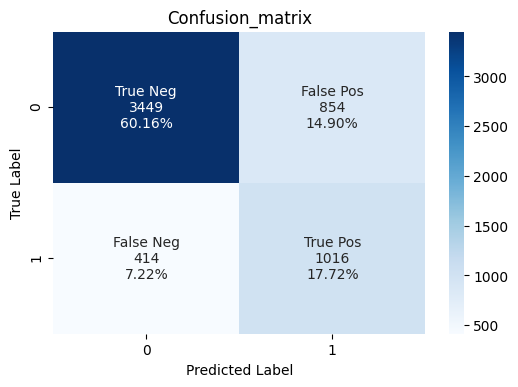

In [111]:
plot_confusion_matrix(cm)

In [112]:
ranforest_results = pd.DataFrame(randfor_gs_ossimp.cv_results_)
table = ranforest_results.pivot_table(values='mean_test_score',
                                index=['param_randforest__max_depth', 'param_tf__cat__imp__strategy', 'param_tf__num__imp__strategy'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_randforest__max_depth param_tf__cat__imp__strategy param_tf__num__imp__strategy                 
8                           most_frequent                mean                                 0.771168
                            constant                     mean                                 0.768169
6                           constant                     mean                                 0.768098
                            most_frequent                mean                                 0.766101
4                           constant                     mean                                 0.763025
                            most_frequent                mean                                 0.761385
3                           constant                     mean                                 0.754635
                            most_frequent                mean                                 0.753177
8                           constant                     median                               0.727172
                            most_frequent                median                               0.726518
6                           constant                     median                               0.722259
2                           constant                     mean                                 0.722070
6                           most_frequent                median                               0.719808
2                           most_frequent                mean                                 0.715348
4                           most_frequent                median                               0.711494
                            constant                     median                               0.710391
3                           constant                     median                               0.700720
                            most_frequent                median                               0.700363
2                           most_frequent                median                               0.689295
                            constant                     median                               0.688157

In [113]:
best = randfor_gs_ossimp.cv_results_['mean_test_score'].max()
model_result_5 = pd.DataFrame([best], index=['RandomForestClassifier + SMOTE + SimpleImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_5)

In [114]:
model_metrics_5 = get_scores(y_valid, y_pred, y_pred_proba, 'RandomForestClassifier + SMOTE + SimpleImputer')
bestmodels_metrics_list.append(model_metrics_5)

## RandomForestClassifier + KNNImputer

### Подготовка

In [115]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

### Модель

In [116]:
randforest_mix_pipe = Pipeline([('scaler', MinMaxScaler())])

randforest_transformers = [('mix', randforest_mix_pipe, num_columns)]
randfor_transformer = ColumnTransformer(transformers=randforest_transformers)

In [117]:
# Создаем экземпляр класса CatBoost
randfor = RandomForestClassifier(n_estimators=50)

In [118]:
# Итоговый конвейер
model = Pipeline([('tf', randfor_transformer),
                  ('imputer', KNNImputer()),
                  ('randforest', randfor)])

In [119]:
# Параметры для GridSearchCV
randfor_param_grid = {
    'randforest__max_depth': [2, 3, 4, 6, 8],
    'imputer__n_neighbors': [13, 17, 21]
}

In [120]:
# Итоговый GridSearchCV
randfor_gs_knn = GridSearchCV(model,
                              randfor_param_grid,
                              cv=5,
                              return_train_score=False,
                              scoring=make_scorer(balanced_accuracy_score))

In [121]:
randfor_gs_knn.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('mix',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['city',
                                                                          'city_development_index',
                                                                          'gender',
                                                                          'relevent_experience',
                                                                          'enrolled_university',
                                                                          'education_level',
                                                                          'major_discipline',

### Результаты

In [122]:
randfor_gs_knn.best_params_

{'imputer__n_neighbors': 21, 'randforest__max_depth': 8}

In [123]:
randfor_gs_knn.best_score_

0.6714505821793768

In [124]:
y_pred = randfor_gs_knn.predict(X_valid_te)
y_pred_proba = randfor_gs_knn.predict_proba(X_valid_te)

In [125]:
cm = confusion_matrix(y_valid, y_pred)

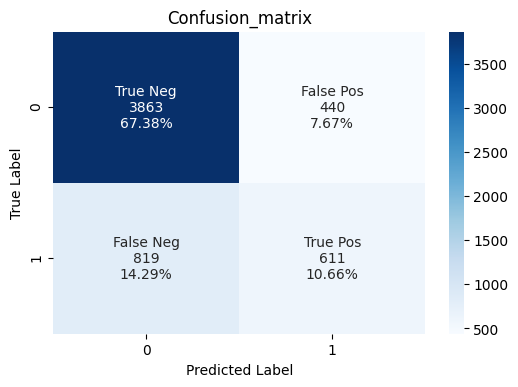

In [126]:
plot_confusion_matrix(cm)

In [127]:
ranforest_results = pd.DataFrame(randfor_gs_knn.cv_results_)
table = ranforest_results.pivot_table(values='mean_test_score',
                                index=['param_randforest__max_depth', 'param_imputer__n_neighbors'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_randforest__max_depth param_imputer__n_neighbors                 
8                           21                                 0.671451
                            13                                 0.670548
                            17                                 0.669401
6                           21                                 0.664745
4                           17                                 0.662144
6                           13                                 0.661445
4                           21                                 0.661395
6                           17                                 0.661246
4                           13                                 0.660044
3                           17                                 0.659243
                            13                                 0.656243
                            21                                 0.651989
2                           21                                 0.605814
                            17                                 0.595962
                            13                                 0.587804

In [128]:
best = randfor_gs_knn.cv_results_['mean_test_score'].max()
model_result_6 = pd.DataFrame([best], index=['RandomForestClassifier + KNNImputer'], columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_6)

In [129]:
model_metrics_6 = get_scores(y_valid, y_pred, y_pred_proba, 'RandomForestClassifier + KNNImputer')
bestmodels_metrics_list.append(model_metrics_6)

## VotingClsf by LogisticRegression & LGBMClassifier & KNNClassifier + SimpleImputer

### Подготовка

In [130]:
cat_columns =  X_train_te.select_dtypes(include='object').columns.tolist()
num_columns =  X_valid_te.select_dtypes(exclude='object').columns.tolist()

### Модель

In [131]:
# Конвейер для количественных переменных
stacking_num_pipe = Pipeline([('imp', SimpleImputer()),
                              ('scaler', MinMaxScaler())])
# Конвейер для категориальных переменных
stacking_cat_pipe = Pipeline([('imp', SimpleImputer())])

# Создание трансформера
stacking_transformers = [('num', stacking_num_pipe, num_columns),
                         ('cat', stacking_cat_pipe, cat_columns)]

stack_transformer = ColumnTransformer(transformers=stacking_transformers)

In [132]:
lgbmclsf = LGBMClassifier(n_estimators=50)
knnclsf = KNeighborsClassifier()
lrclsf = LogisticRegression()
clf_st = VotingClassifier(estimators=[('lr', lrclsf), ('lgbm', lgbmclsf), ('knn', knnclsf)], voting='soft')

In [133]:
# Итоговый конвейер
model = Pipeline([('tf', stack_transformer),
                  ('stack', clf_st)])

In [134]:
stack_grid = {
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'tf__num__imp__strategy': ['mean', 'median'],
    'stack__lr__C': [1, 2],
    'stack__lgbm__max_depth':[2, 4],
    'stack__knn__n_neighbors':[3, 7]
}

In [135]:
stack_gs = GridSearchCV(model,
                        stack_grid,
                        cv=5,
                        return_train_score=False,
                        scoring=make_scorer(balanced_accuracy_score))

In [136]:
stack_gs.fit(X_train_te, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['city',
                                                                          'city_development_index',
                                                                          'gender',
                                                                          'relevent_experience',
                                                                          'enr

### Результаты

In [137]:
stack_gs.best_params_

{'stack__knn__n_neighbors': 7,
 'stack__lgbm__max_depth': 4,
 'stack__lr__C': 2,
 'tf__cat__imp__strategy': 'most_frequent',
 'tf__num__imp__strategy': 'mean'}

In [138]:
stack_gs.best_score_

0.6564893159854465

In [139]:
y_pred = stack_gs.predict(X_valid_te)
y_pred_proba = stack_gs.predict_proba(X_valid_te)

In [140]:
cm = confusion_matrix(y_valid, y_pred)

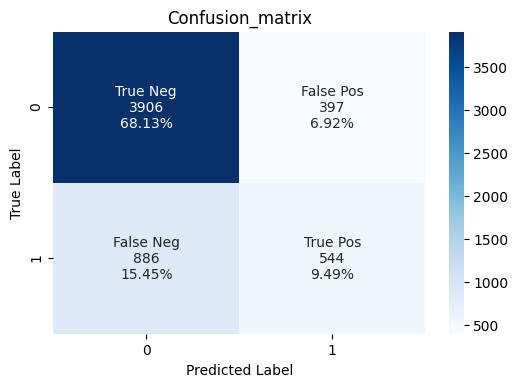

In [141]:
plot_confusion_matrix(cm)

In [142]:
stack_results = pd.DataFrame(stack_gs.cv_results_)
table = stack_results.pivot_table(values='mean_test_score',
                                  index=['param_tf__num__imp__strategy',
                                         'param_tf__cat__imp__strategy',
                                         'param_stack__lr__C',
                                         'param_stack__lgbm__max_depth',
                                         'param_stack__knn__n_neighbors'])
table.sort_values(by='mean_test_score', ascending=False)

mean_test_score
param_tf__num__imp__strategy param_tf__cat__imp__strategy param_stack__lr__C param_stack__lgbm__max_depth param_stack__knn__n_neighbors                 
mean                         constant                     2                  4                            7                                     0.656489
                             most_frequent                2                  4                            7                                     0.656489
                                                          1                  4                            7                                     0.656189
                             constant                     1                  4                            7                                     0.656189
median                       constant                     2                  4                            7                                     0.648591
                             most_frequent                2                  4                            7                                     0.648591
                                                          1                  4                            7                                     0.648491
                             constant                     1                  4                            7                                     0.648491
mean                         constant                     2                  2                            7                                     0.647232
                             most_frequent                2                  2                            7                                     0.647232
                                                          1                  2                            7                                     0.646932
                             constant                     1                  2                            7                                     0.646932
                                                          2                  4                            3                                     0.646889
                             most_frequent                2                  4                            3                                     0.646889
                                                          1                  4                            3                                     0.646789
                             constant                     1                  4                            3                                     0.646789
median                       constant                     1                  2                            7                                     0.641438
                             most_frequent                1                  2                            7                                     0.641438
                                                          2                  2                            7                                     0.641289
                             constant                     2                  2                            7                                     0.641289
mean                         constant                     2                  2                            3                                     0.638734
                             most_frequent                2                  2                            3                                     0.638734
                             constant                     1                  2                            3                                     0.638484
                             most_frequent                1                  2                            3                                     0.638484
median                       constant                     2                  4                            3                                     0.637540
      

In [143]:
best = stack_gs.cv_results_['mean_test_score'].max()
model_result_7 = pd.DataFrame([best], 
                              index=['VotingClsf by LogReg & LGBMClassifier & KNNClassifier + SimpleImputer'], 
                              columns=['mean_test_score'])
bestmodels_accuracy_list.append(model_result_7)

In [144]:
model_metrics_7 = get_scores(y_valid, y_pred, y_pred_proba, 'VotingClsf by LogReg & LGBMClassifier & KNNClassifier + SimpleImputer')
bestmodels_metrics_list.append(model_metrics_7)

# Overview

In [145]:
# Сводная таблица моделей по mean_test_score
overview_accuracy_df = pd.concat(bestmodels_accuracy_list)
overview_accuracy_df.sort_values(by='mean_test_score', ascending=False)

,mean_test_score
RandomForestClassifier + SMOTE + SimpleImputer,0.771168
CatBoost + SMOTE + SimpleImputer,0.758261
CatBoost + SimpleImputer,0.721221
CatBoost + KNNImputer,0.690860
RandomForestClassifier + SimpleImputer,0.671645
RandomForestClassifier + KNNImputer,0.671451
VotingClsf by LogReg & LGBMClassifier & KNNClassifier + SimpleImputer,0.656489


In [146]:
# Сводная таблица моделей с метриками
overview_metrics_df = pd.concat(bestmodels_metrics_list)
overview_metrics_df

,Accuracy,ROC-AUC,F1,Precision_0,Precision_1,Recall_0,Recall_1
CatBoost + SimpleImputer,0.789988,0.792329,0.567218,0.853686,0.583580,0.869161,0.551748
CatBoost + SMOTE + SimpleImputer,0.789813,0.787260,0.601653,0.874335,0.570533,0.840809,0.636364
CatBoost + KNNImputer,0.787023,0.786174,0.531646,0.838235,0.588785,0.887520,0.484615
RandomForestClassifier + SimpleImputer,0.781092,0.789857,0.491285,0.824532,0.584378,0.899837,0.423776
RandomForestClassifier + SMOTE + SimpleImputer,0.778824,0.790163,0.615758,0.892829,0.543316,0.801534,0.710490
RandomForestClassifier + KNNImputer,0.780394,0.784084,0.492543,0.825075,0.581351,0.897746,0.427273
VotingClsf by LogReg & LGBMClassifier & KNNClassifier + SimpleImputer,0.776208,0.783784,0.458878,0.815109,0.578108,0.907739,0.380420


In [147]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

In [148]:
overview_metrics_df.reset_index(drop=True).style.apply(highlight_max)

,Accuracy,ROC-AUC,F1,Precision_0,Precision_1,Recall_0,Recall_1
0,0.789988,0.792329,0.567218,0.853686,0.583580,0.869161,0.551748
1,0.789813,0.787260,0.601653,0.874335,0.570533,0.840809,0.636364
2,0.787023,0.786174,0.531646,0.838235,0.588785,0.887520,0.484615
3,0.781092,0.789857,0.491285,0.824532,0.584378,0.899837,0.423776
4,0.778824,0.790163,0.615758,0.892829,0.543316,0.801534,0.710490
5,0.780394,0.784084,0.492543,0.825075,0.581351,0.897746,0.427273
6,0.776208,0.783784,0.458878,0.815109,0.578108,0.907739,0.380420


## Подготовка TRAIN и TEST

In [157]:
TEST = pd.read_csv('C:/Users/malya/Desktop/Datasets/HR/HR Analytics Job Change of Data Scientists/aug_test.csv')
TEST.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [163]:
# ID для посылки
iden = TEST['enrollee_id']
del TEST['enrollee_id']

In [164]:
TRAIN = features.copy()

### Укрупнение редких категорий

In [159]:
raregrouper = RareGrouper(threshold=(30/20000))
raregrouper.fit(TRAIN[['city']])
TRAIN['city'] = raregrouper.transform(TRAIN[['city']])
TEST['city'] = raregrouper.transform(TEST[['city']])

In [160]:
# TRAIN - TEST
check_diff_categories(TRAIN, TEST)

{}

In [161]:
# TEST - TRAIN
check_diff_categories(TEST, TRAIN)

{}

### Polynominal feature

In [165]:
num_columns =  TEST.select_dtypes(exclude='object').columns.tolist()

In [166]:
# Генерация новых количественных признаков для TEST
new_features_poly_test = poly_nam_features(TEST, num_columns, 2)
new_features_poly_test.head()

,city_development_index,training_hours,city_development_index^2,city_development_index training_hours,training_hours^2
0,0.827,21.0,0.683929,17.367,441.0
1,0.920,98.0,0.846400,90.160,9604.0
2,0.624,15.0,0.389376,9.360,225.0
3,0.827,39.0,0.683929,32.253,1521.0
4,0.920,72.0,0.846400,66.240,5184.0


In [167]:
# Добавление новых количественных признаков в TEST
TEST[new_features_poly.columns] = new_features_poly
TEST.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,city_development_index^2,city_development_index training_hours,training_hours^2
0,city_41,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,36.0,0.846400,33.120,1296.0
1,city_103,0.776,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,47.0,0.602176,36.472,2209.0
2,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,83.0,0.389376,51.792,6889.0
3,city_13,0.789,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,52.0,0.622521,41.028,2704.0
4,city_103,0.767,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,8.0,0.588289,6.136,64.0


## Обучение итоговой модели

In [171]:
best_params = randfor_gs_ossimp.best_params_
best_params

{'randforest__max_depth': 8,
 'tf__cat__imp__strategy': 'most_frequent',
 'tf__num__imp__strategy': 'mean'}

In [177]:
model.set_params(**best_params)

Pipeline(steps=[('tf',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('norm',
                                                                   MinMaxScaler())]),
                                                  ['city_development_index',
                                                   'training_hours'])])),
                ('sampling', SMOTE()),
                ('randforest',
                 RandomForestClassifier(max_depth=8, n_estimators=50))])

In [178]:
randfor_gs_ossimp.fit(TRAIN, target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('norm',
                                                                                          MinMaxScaler())]),
                                                      

In [179]:
randfor_gs_ossimp.best_score_

0.6678828569313525

# Submission

In [180]:
y_pred_proba = randfor_gs_ossimp.predict_proba(TEST)[:, -1]

In [181]:
# Посылка для Kaggle
subm = pd.DataFrame(y_pred_proba, index=iden, columns=['target'])
subm.head()

,target
enrollee_id,
32403,0.411713
9858,0.410484
31806,0.756224
27385,0.406868
27724,0.406215


In [182]:
subm.to_csv('subm.csv')